In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Define the path to the existing combined CSV file
combined_csv_path = '/content/drive/MyDrive/ELEG605/prj/combined_traffic_data_binary.csv'

# Define mappings for each device
device_mapping = {
    'Danmini_Doorbell': 0,
    'Ecobee_Thermostat': 1,
    'Ennio_Doorbell': 2,
    'Philips_B120N10_Baby_Monitor': 3,
    'Provision_PT_737E_Security_Camera': 4,
    'Provision_PT_838_Security_Camera': 5,
    'Samsung_SNH_1011_N_Webcam': 6,
    'SimpleHome_XCS7_1002_WHT_Security_Camera': 7,
    'SimpleHome_XCS7_1003_WHT_Security_Camera': 8
}

# Prepare the one-hot encoder for all device labels
device_labels = [[label] for label in device_mapping.values()]
one_hot_encoder = OneHotEncoder(sparse_output=False)
device_one_hot_encoded = one_hot_encoder.fit_transform(device_labels)

# Create a dictionary to map device names to their one-hot encodings
device_one_hot_map = {
    device: device_one_hot_encoded[idx] for idx, device in enumerate(device_mapping.keys())
}

# Initialize dictionaries to count benign and attack records for each device
benign_counts = {device: 0 for device in device_mapping.keys()}
attack_counts = {device: 0 for device in device_mapping.keys()}

# Process the CSV in chunks
chunksize = 10000  # Adjust the chunk size as needed
for chunk in pd.read_csv(combined_csv_path, chunksize=chunksize):
    # For each device, count benign and attack records in the current chunk
    for device, encoding in device_one_hot_map.items():
        # Identify rows in the chunk that correspond to the current device
        condition = (chunk[one_hot_encoder.get_feature_names_out(['device_type'])] == encoding).all(axis=1)

        # Count benign and attack records
        benign_counts[device] += chunk[condition & (chunk['target'] == 0)].shape[0]
        attack_counts[device] += chunk[condition & (chunk['target'] == 1)].shape[0]

# Display benign and attack record counts per device
print("Record counts per device:")
for device in device_mapping.keys():
    print(f"{device}: {benign_counts[device]} benign records, {attack_counts[device]} attack records")


Record counts per device:
Danmini_Doorbell: 49548 benign records, 968750 attack records
Ecobee_Thermostat: 13113 benign records, 822763 attack records
Ennio_Doorbell: 39100 benign records, 316400 attack records
Philips_B120N10_Baby_Monitor: 175240 benign records, 923437 attack records
Provision_PT_737E_Security_Camera: 62154 benign records, 766106 attack records
Provision_PT_838_Security_Camera: 98514 benign records, 738377 attack records
Samsung_SNH_1011_N_Webcam: 52150 benign records, 323072 attack records
SimpleHome_XCS7_1002_WHT_Security_Camera: 46585 benign records, 816471 attack records
SimpleHome_XCS7_1003_WHT_Security_Camera: 19528 benign records, 831298 attack records


In [ ]:
chunk_size = 10000
device_counts_total = pd.Series(dtype=float)

for chunk in pd.read_csv('/content/drive/MyDrive/ELEG605/prj/combined_traffic_data_binary.csv', chunksize=chunk_size):
    device_columns = [col for col in chunk.columns if 'device_type' in col]
    device_counts_chunk = chunk[device_columns].sum()
    device_counts_total = device_counts_total.add(device_counts_chunk, fill_value=0)

print("Total Device Type Counts in Full Dataset:")
print(device_counts_total)




Total Device Type Counts in Full Dataset:
device_type_0    1018298.0
device_type_1     835876.0
device_type_2     355500.0
device_type_3    1098677.0
device_type_4     828260.0
device_type_5     836891.0
device_type_6     375222.0
device_type_7     863056.0
device_type_8     850826.0
dtype: float64


In [ ]:
import pandas as pd


device_counts_total = pd.Series({
    "device_type_0": 1018298.0,
    "device_type_1": 835876.0,
    "device_type_2": 355500.0,
    "device_type_3": 1098677.0,
    "device_type_4": 828260.0,
    "device_type_5": 836891.0,
    "device_type_6": 375222.0,
    "device_type_7": 863056.0,
    "device_type_8": 850826.0
})


device_distribution_percentage = (device_counts_total / device_counts_total.sum()) * 100
device_distribution_percentage = device_distribution_percentage.round(2)
device_distribution_percentage


,0
device_type_0,14.42
device_type_1,11.84
device_type_2,5.03
device_type_3,15.56
device_type_4,11.73
device_type_5,11.85
device_type_6,5.31
device_type_7,12.22
device_type_8,12.05


In [ ]:
import pandas as pd


file_path = '/content/drive/MyDrive/ELEG605/prj/combined_traffic_data_binary.csv'

# Initialize counters for each class in the binary target
benign_count = 0
attack_count = 0

# Define chunk size for processing
chunk_size = 10000

# Process the file in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Count occurrences of each class in the target column
    benign_count += (chunk['target'] == 0).sum()
    attack_count += (chunk['target'] == 1).sum()

# Output the counts
total_count = benign_count + attack_count
benign_percentage = (benign_count / total_count) * 100
attack_percentage = (attack_count / total_count) * 100

print(f"Benign (0): {benign_count} ({benign_percentage:.2f}%)")
print(f"Attack (1): {attack_count} ({attack_percentage:.2f}%)")
print(f"Total Records: {total_count}")


Benign (0): 555932 (7.87%)
Attack (1): 6506674 (92.13%)
Total Records: 7062606


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


data_path = '/content/drive/MyDrive/ELEG605/prj/combined_traffic_data_binary.csv'

# Function to load and balance data in chunks
def balance_data_in_chunks(file_path, chunksize=100000):
    balanced_chunks = []


    smote = SMOTE(sampling_strategy=1.0, random_state=42)
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        X = chunk.drop(columns=['target'])
        y = chunk['target']


        try:
            X_smote, y_smote = smote.fit_resample(X, y)
        except ValueError as e:
            print(f"Skipping chunk due to SMOTE error: {e}")
            continue


        X_balanced, y_balanced = undersampler.fit_resample(X_smote, y_smote)

        balanced_chunk = pd.DataFrame(X_balanced, columns=X.columns)
        balanced_chunk['target'] = y_balanced

        balanced_chunks.append(balanced_chunk)

        print(f"Chunk class distribution: {Counter(y_balanced)}")

    balanced_data = pd.concat(balanced_chunks, ignore_index=True)
    return balanced_data


balanced_df = balance_data_in_chunks(data_path)

balanced_df.to_csv('/content/drive/MyDrive/ELEG605/prj/highly_balanced_traffic_data_binary.csv', index=False)
print("Balanced data saved to 'highly_balanced_traffic_data_binary.csv'")

final_balance = Counter(balanced_df['target'])
print("\nFinal class distribution in the balanced dataset:")
print(f"Benign (0): {final_balance[0]} ({(final_balance[0] / len(balanced_df)) * 100:.2f}%)")
print(f"Attack (1): {final_balance[1]} ({(final_balance[1] / len(balanced_df)) * 100:.2f}%)")
print(f"Total Records: {len(balanced_df)}")


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 60900, 1: 60900})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 55500, 1: 55500})


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 94952, 1: 94952})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 73798, 1: 73798})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 50962, 1: 50962})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 86887, 1: 86887})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 53415, 1: 53415})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 80472, 1: 80472})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 77767, 1: 77767})


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 79253, 1: 79253})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 59124, 1: 59124})


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 78722, 1: 78722})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 87384, 1: 87384})


<ipython-input-19-692e008b23d3>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_chunk['target'] = y_balanced


Chunk class distribution: Counter({0: 60466, 1: 60466})
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Skipping chunk due to SMOTE error: The target 'y' needs to have more than 1 class. Got 1 class instead
Balanced data saved to 'highly_balanced_traffic_data_binary.csv'

Final class distribution in the balanced dataset:
Benign (0): 999602 (50.00%)
Attack (1): 999602 (50.00%)
Total Records: 1999204


In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer


data_path = '/content/drive/MyDrive/ELEG605/prj/highly_balanced_traffic_data_binary.csv'

chunksize = 100000


imputer = SimpleImputer(strategy='mean')

cleaned_chunks = []

def check_missing_values(chunk):
    missing_values = chunk.isnull().sum()
    total_missing = missing_values.sum()
    if total_missing > 0:
        print("Missing values in this chunk:")
        print(missing_values[missing_values > 0])
    else:
        print("No missing values in this chunk.")

def clean_chunk(chunk):
    check_missing_values(chunk)


    chunk_imputed = pd.DataFrame(imputer.fit_transform(chunk), columns=chunk.columns)
    chunk_cleaned = chunk_imputed.drop_duplicates()

    return chunk_cleaned

for chunk in pd.read_csv(data_path, chunksize=chunksize):
    cleaned_chunk = clean_chunk(chunk)
    cleaned_chunks.append(cleaned_chunk)
    print(f"Processed and cleaned chunk size: {cleaned_chunk.shape}")

cleaned_data = pd.concat(cleaned_chunks, ignore_index=True)

print("\nSummary of cleaned data:")
print(cleaned_data.info())
print("Sample of cleaned data:")
print(cleaned_data.head())


No missing values in this chunk.
Processed and cleaned chunk size: (72997, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (70978, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (84385, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (50215, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (84646, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (100000, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (76880, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (99991, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (95689, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (79858, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (98822, 125)
No missing values in this chunk.
Processed and cleaned chunk size: (97800, 125)
No missing values in this chunk.
Proces

In [5]:
import pandas as pd
import numpy as np


data_path = '/content/drive/MyDrive/ELEG605/prj/combined_traffic_data_binary.csv'
output_path = 'dataset_statistics.csv'


mean_values = None
median_values = None
mode_values = None
range_values = None
chunk_count = 0
def calculate_statistics(chunk):
    # Mean, Median, Mode, and Range
    mean_chunk = chunk.mean()
    median_chunk = chunk.median()
    mode_chunk = chunk.mode().iloc[0]
    range_chunk = chunk.max() - chunk.min()

    return mean_chunk, median_chunk, mode_chunk, range_chunk

for chunk in pd.read_csv(data_path, chunksize=100000):
    mean_chunk, median_chunk, mode_chunk, range_chunk = calculate_statistics(chunk)


    if mean_values is None:
        mean_values = mean_chunk
        median_values = median_chunk
        mode_values = mode_chunk
        range_values = range_chunk
    else:
        mean_values += mean_chunk
        median_values += median_chunk
        mode_values += mode_chunk
        range_values += range_chunk

    chunk_count += 1


mean_values /= chunk_count
median_values /= chunk_count
range_values /= chunk_count

# Create a DataFrame to store all statistics
statistics_df = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Mode': mode_values,
    'Range': range_values
})

# Save statistics to CSV
statistics_df.to_csv(output_path, index_label="Feature")
print(f"Statistics saved to '{output_path}'")


Statistics saved to 'dataset_statistics.csv'


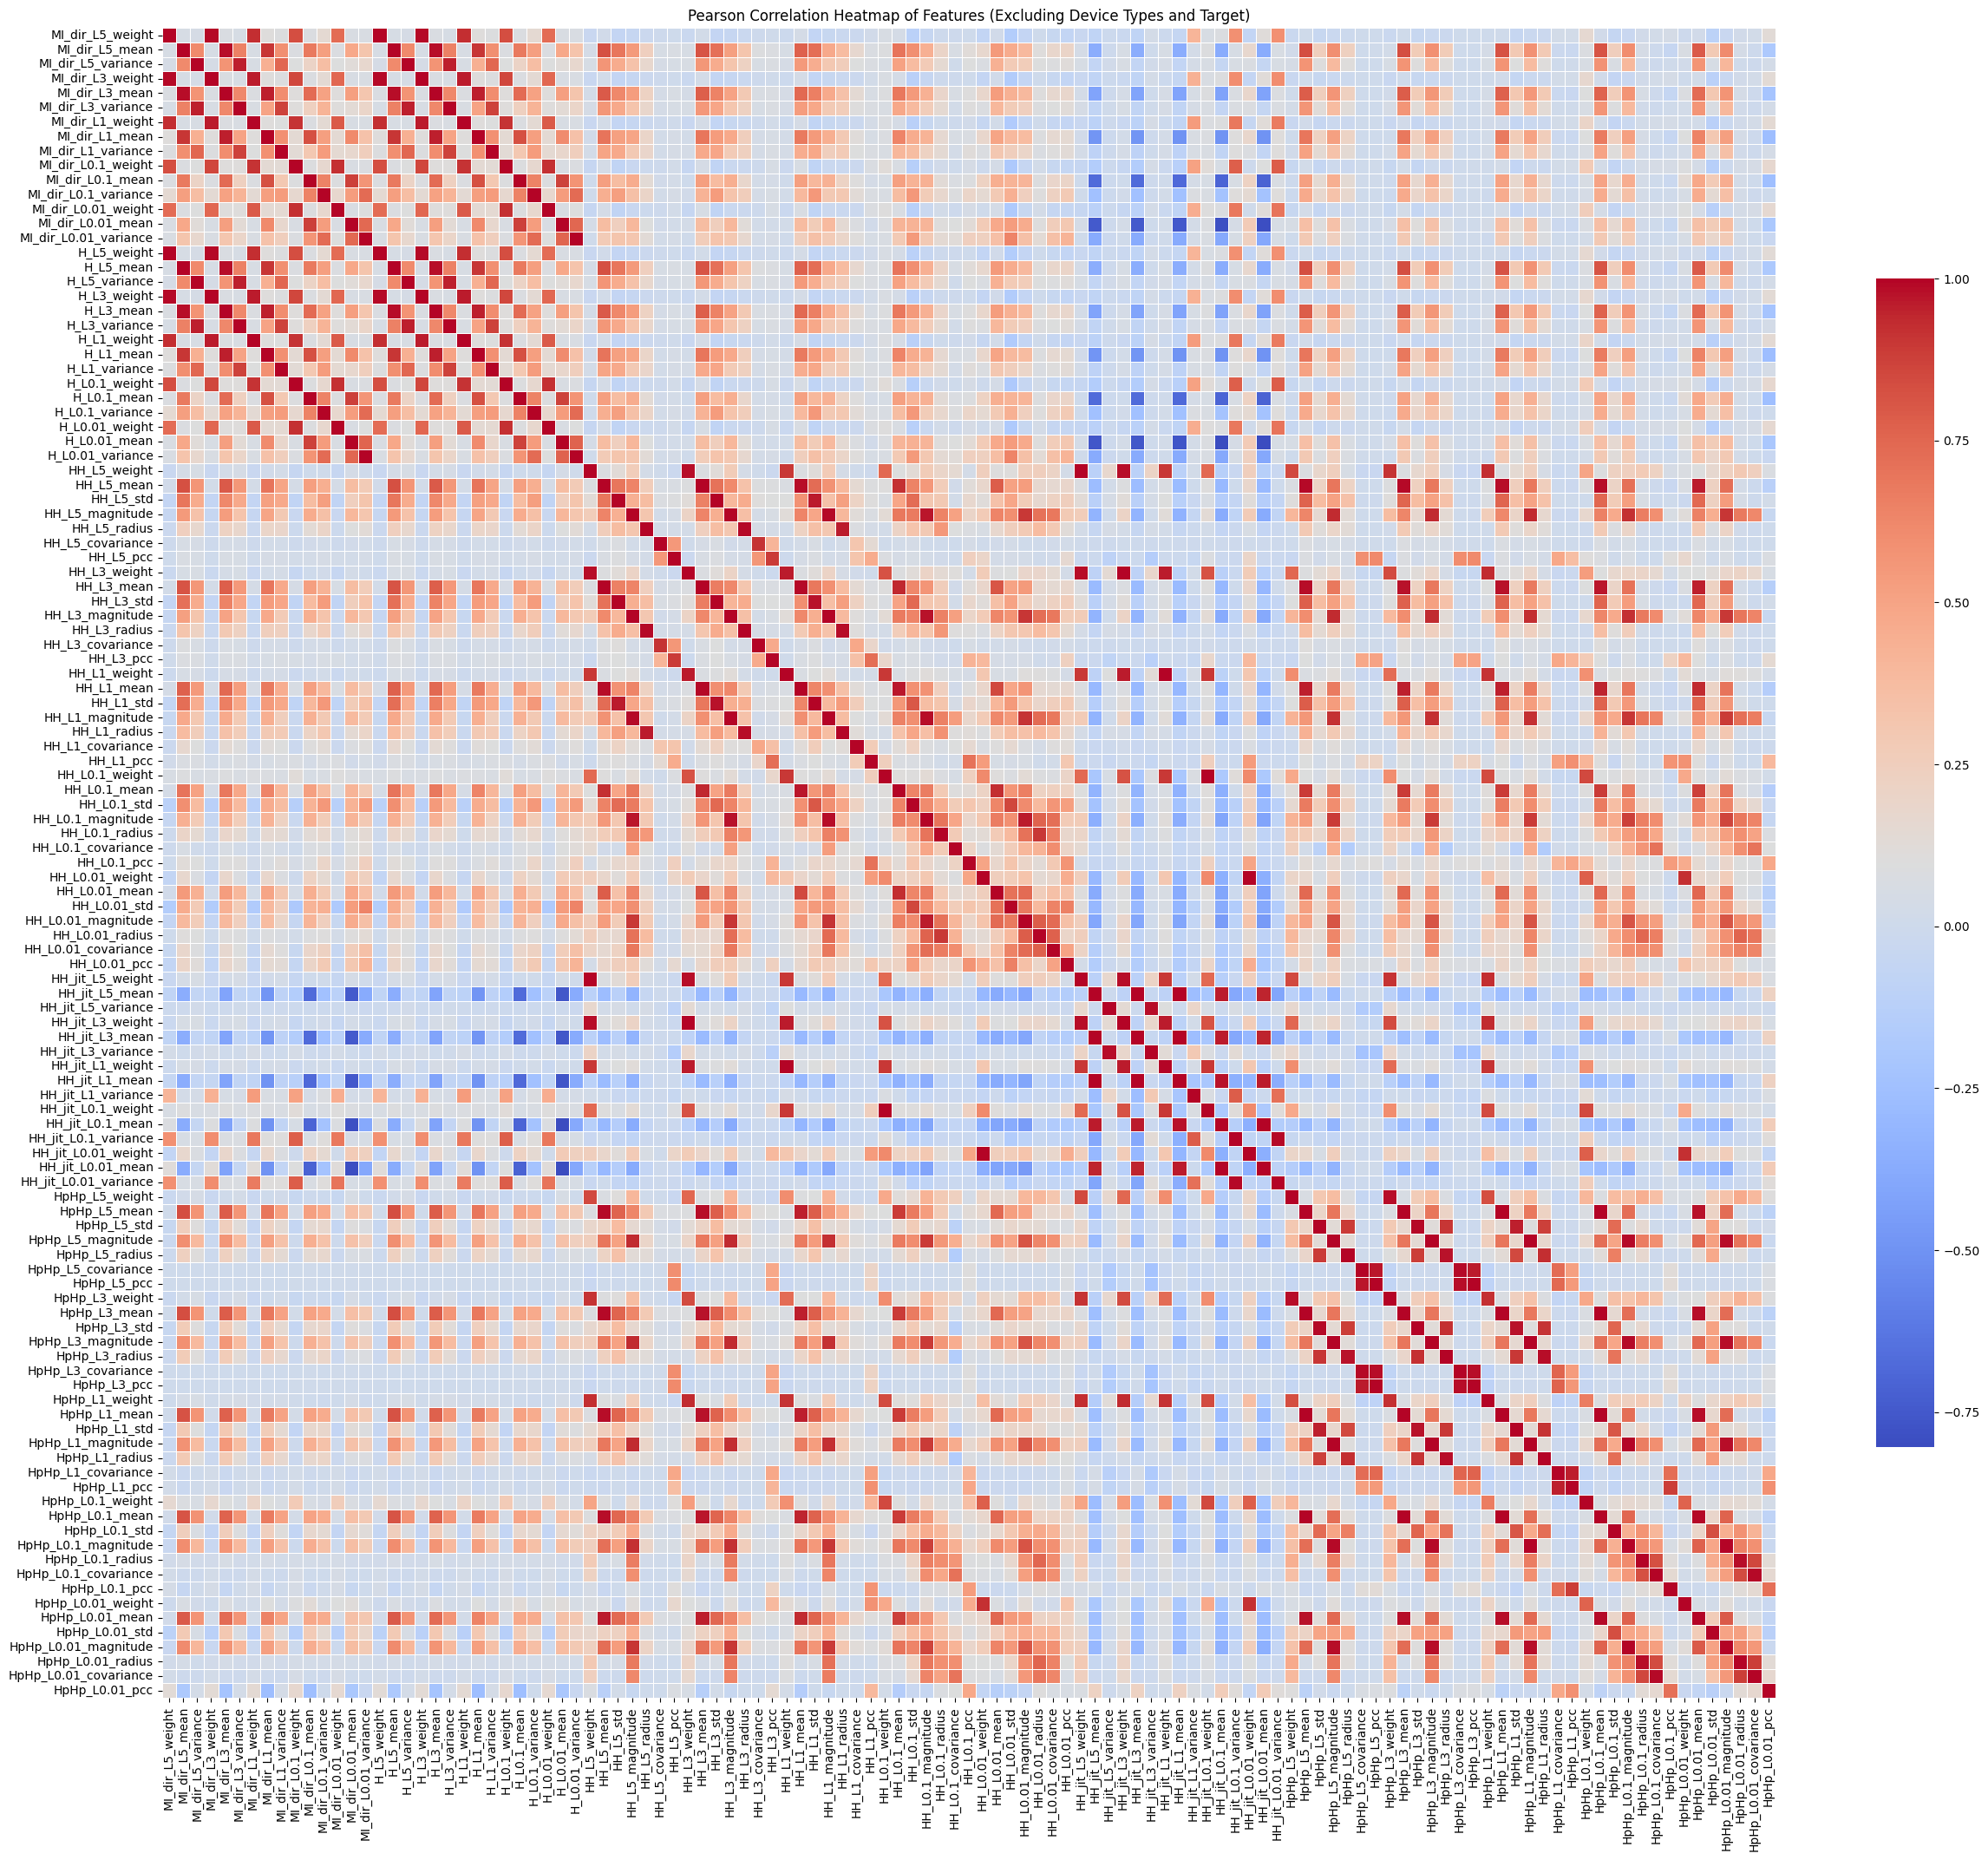

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data_path = '/content/drive/MyDrive/ELEG605/prj/combined_traffic_data_binary.csv'
chunk_size = 100000

chunks = []
for chunk in pd.read_csv(data_path, chunksize=chunk_size):
    chunks.append(chunk)
    if len(chunks) >= 1:
        break
sample_df = pd.concat(chunks, ignore_index=True)

# Drop the device type and target columns
columns_to_exclude = [col for col in sample_df.columns if 'device_type' in col] + ['target']
sample_df = sample_df.drop(columns=columns_to_exclude)

# Calculate the Pearson correlation matrix
correlation_matrix = sample_df.corr()


plt.figure(figsize=(30, 25))


sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": .7})


plt.title("Pearson Correlation Heatmap of Features (Excluding Device Types and Target)")


plt.savefig("pearson_correlation_heatmap.pdf", format="pdf", bbox_inches="tight")

plt.show()


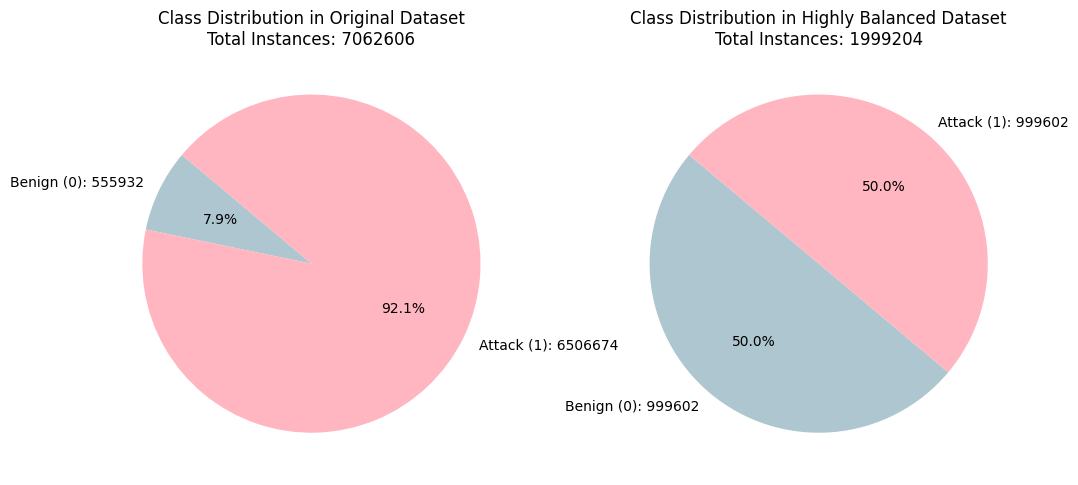

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages


original_data_path = '/content/drive/MyDrive/ELEG605/prj/combined_traffic_data_binary.csv'
balanced_data_path = '/content/drive/MyDrive/ELEG605/prj/highly_balanced_traffic_data_binary.csv'


def calculate_class_distribution(file_path, chunksize=100000):
    counter = Counter()
    total_instances = 0
    for chunk in pd.read_csv(file_path, usecols=['target'], chunksize=chunksize):
        counter.update(chunk['target'])
        total_instances += len(chunk)
    return counter, total_instances


original_counter, original_total = calculate_class_distribution(original_data_path)
balanced_counter, balanced_total = calculate_class_distribution(balanced_data_path)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Dataset
axes[0].pie([original_counter[0], original_counter[1]],
            labels=[f'Benign (0): {original_counter[0]}', f'Attack (1): {original_counter[1]}'],
            autopct='%1.1f%%', startangle=140, colors=['#aec6cf', '#ffb6c1'])
axes[0].set_title("Class Distribution in Original Dataset\n"
                  f"Total Instances: {original_total}")

# Balanced Dataset
axes[1].pie([balanced_counter[0], balanced_counter[1]],
            labels=[f'Benign (0): {balanced_counter[0]}', f'Attack (1): {balanced_counter[1]}'],
            autopct='%1.1f%%', startangle=140, colors=['#aec6cf', '#ffb6c1'])
axes[1].set_title("Class Distribution in Highly Balanced Dataset\n"
                  f"Total Instances: {balanced_total}")


with PdfPages('/content/class_distribution_comparison.pdf') as pdf:
    pdf.savefig(fig, bbox_inches="tight")

plt.show()
